In [ ]:
import matplotlib.pyplot as plt
import csv
import numpy

import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#from keras import backend as K
#K.set_session(sess)

from keras.preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

from PIL import Image


In [ ]:
# Размер мини-выборки
batch_size = 32
# Количество классов изображений
nb_classes = 43
# Количество эпох для обучения
nb_epoch = 6
# Размер изображений
img_rows, img_cols = 48, 48
# Количество каналов в изображении: RGB
img_channels = 3


In [ ]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-' + format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.__next__() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            with Image.open(prefix + row[0]) as img:
                img = img.resize((img_rows, img_cols))
                imgarray = numpy.asarray(img)
#                 imgarray = imgarray[:,:,0]
                images.append(imgarray) # the 1th column is the filename
                
#             images.append(plt.imread(prefix + row[0]))
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [ ]:
trainImages, trainLabels = readTrafficSigns('C:/Users/tonym/YandexDisk/python/CRT_testing_work/GTSRB/Training')

# тема с преобразование только в Y канал 

In [ ]:
from sklearn.utils import shuffle
from skimage import exposure

def preprocess_dataset(X):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #X = 0.700 * X[:, :, :, 0] + 0.100 * X[:, :, :, 1] + 0.200 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(numpy.float32)
      
    # Apply localized histogram localization  
    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])
        
    #if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        #y = numpy.eye(43)[y]
        # Shuffle the data
        #X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X


In [ ]:
X_train = preprocess_dataset(numpy.asarray(trainImages))
Y_train = np_utils.to_categorical(trainLabels, nb_classes)
print(len(trainLabels), len(trainImages))

In [ ]:
def show_oneYpic(img):
    a = numpy.zeros((32,32,3),numpy.uint8)
    a[:,:,0] = img[:,:,0]*255 
    a[:,:,1] = img[:,:,0]*255 
    a[:,:,2] = img[:,:,0]*255 
    #print(a)
    plt.imshow(a,cmap="gray")
    plt.show() 

    
X = X_train[:10]
for i in range(10):
    print(X[i].shape)
    show_oneYpic(X[i])

# вариант с генератором 

In [ ]:
X_train = numpy.asarray(trainImages)/255
Y_train = np_utils.to_categorical(trainLabels, nb_classes)
print(len(trainLabels), len(trainImages))

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# Модель

In [41]:

# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(100, (7, 7), padding='same', input_shape=(img_rows, img_cols, img_channels), activation='relu'))

# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# Второй сверточный слой
model.add(Conv2D(150, (4, 4), activation='relu', padding='same'))

# второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# # Слой регуляризации Dropout
# model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(250, (4, 4), padding='same', activation='relu'))

# второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))


# # Четвертый сверточный слой
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # Второй слой подвыборки
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # Слой регуляризации Dropout
# model.add(Dropout(0.25))
# # Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(300, activation='relu'))

#model.add(Dense(1024, activation='softmax'))

# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


# обучение

In [ ]:
model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2) 

# С генератором

In [46]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
              epochs=nb_epoch,steps_per_epoch = 1000,
              verbose=2)

Epoch 1/1
7s - loss: 0.0631 - acc: 0.9822


# сохранение 

In [ ]:
model_json = model.to_json()
json_file = open("C:/Users/tonym/YandexDisk/python/CRT_testing_work/sec_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("C:/Users/tonym/YandexDisk/python/CRT_testing_work/sec_model.h5")


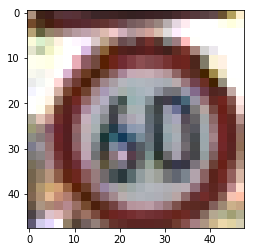

3


In [32]:
img = load_img("C:\\Users\\tonym\\YandexDisk\\python\\CRT_testing_work\\TrainIJCNN2013\\03\\00007.ppm", target_size=(img_rows, img_cols))
plt.imshow(img)
plt.show()
X =img_to_array(img)/255
X = numpy.expand_dims(X, axis=0)
pre = model.predict(X)
print(numpy.argmax(pre))

In [11]:
X =img_to_array(img)/255
X = numpy.expand_dims(X, axis=0)
pre = model.predict(X)
print(numpy.argmax(pre))

0


In [ ]:
fimages = [] # images
fimages.append(img_to_array(img)) # the 1th column is the filename     
X = preprocess_dataset(numpy.asarray(fimages))
show_oneYpic(X[0])
pre = model.predict(X)
print(numpy.argmax(pre))
# pre = np_utils.categorical_probas_to_classes(pre)
# print(pre[0])

In [ ]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print(scores)

In [ ]:
print("Точность работы сети на обучающей выборке: %.2f%%" % (scores[1]*100))

In [58]:
X_test = [] # images
Y_test = [] # corresponding labels
for i in range(43):
    prefix = 'C:/Users/tonym/YandexDisk/python/CRT_testing_work/TrainIJCNN2013/' + format(i, '02d') + '/' # subdirectory for class
    j = 0
    while True:
        try:
            img = load_img(prefix + format(j,"05d") +'.ppm', target_size=(img_rows, img_cols))
            #plt.imshow(img)
            #plt.show()
            #X_test = X_test.astype('float32')
#             X =img_to_array(img)/255
#             X = numpy.expand_dims(X, axis=0)
#             res = numpy.argmax(model.predict(X))
            print(str(i) + " - " + str(res))
#             X_test.append(X) # the 1th column is the filename
#             Y_test.append(i) # the 8th column is the label
            X_test.append(img_to_array(img)) # the 1th column is the filename
            Y_test.append(i)
        except IOError as e:
            break
        j+=1

    

0 - 3
0 - 3
0 - 3
0 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
1 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
2 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
3 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
4 - 3
5 - 3
5 - 3
5 - 3
5 - 

In [59]:
# print(X_test)
X_test = numpy.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

In [61]:
Y_t = np_utils.to_categorical(Y_test, nb_classes)
scores = model.evaluate(X_test, Y_t, verbose=0)
print("Точность работы загруженной сети на тестовых данных: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Точность работы загруженной сети на обучающей выборке: %.2f%%" % (scores[1]*100))

Точность работы загруженной сети на тестовых данных: 69.75%
Точность работы загруженной сети на обучающей выборке: 81.14%
